In [73]:
using Plots, DifferentialEquations
using LinearAlgebra
using NLopt
using .Threads 
using Interpolations
using Distributions
using Roots
gr();


$$
\dfrac{\textrm{d}C_1(t)}{\textrm{d}t} = \lambda_1 C_1(t) \left[1 - \dfrac{S(t)}{K} \right]\\
    \dfrac{\textrm{d}C_2(t)}{\textrm{d}t} = \lambda_2 C_2(t) \left[1 - \dfrac{S(t)}{K} \right] - \delta C_2(t) \left( \dfrac{C_1(t)}{K} \right)\\
S(t) = C_1(t) + C_2(t)
$$

In [74]:
a=zeros(9)
λ1g=0.002;
λ2g=0.002;
δg=0.0;
KKg=80.0;
C0g=[1.0,1.0];
Vg=1.0;

In [75]:
t1=[0
769
1140
1488
1876
2233
2602
2889
3213
3621
4028
]

data11=[0.133333333
 4.115503909
 10.82448589
 26.29988404
 41.62258065
 52.1
 57.29019608
 51.74864865
 61.9804878
 72.16281407
 69.66331658];


data12=[0.406212664
 1.303495993
 1.505499761
 0.90407164
 2.783870968
 1.4
 0.7
 0.308108108
 0.395121951
 0.9
 1.300502513];

In [76]:
function DE!(dC,C,p,t)
λ1,λ2,δ,KK=p
S=C[1]+C[2]
dC[1]=λ1*C[1]*(1.0-S/KK)
dC[2]=λ2*C[2]*(1.0-S/KK)-δ*C[2]*C[1]/KK;
end

DE! (generic function with 1 method)

In [77]:
function odesolver(t1,λ1,λ2,δ,KK,C01,C02)
p=(λ1,λ2,δ,KK)
C0=[C01,C02]
tspan=(0.0,maximum(t1))
prob=ODEProblem(DE!,C0,tspan,p)
sol=solve(prob,saveat=t1)
return sol[1,:],sol[2,:]
end

odesolver (generic function with 1 method)

In [78]:
function odesolver2(t1,λ1,λ2,δ,KK,C01,C02)
p=(λ1,λ2,δ,KK)
C0=[C01,C02]
tspan=(0.0,maximum(t1))
prob=ODEProblem(DE!,C0,tspan,p)
sol=solve(prob)
tt=sol.t[:]
return sol[1,:],sol[2,:],tt
end

odesolver2 (generic function with 1 method)

In [79]:
function model(t1,a)
y1=zeros(length(t1))
y2=zeros(length(t1))
(y1,y2)=odesolver(t1,a[1],a[2],a[3],a[4],a[5],a[6])
return y1,y2
end

model (generic function with 1 method)

In [80]:
function error(data11,data12,a)
y1=zeros(length(t1))
y2=zeros(length(t1))
(y1,y2)=model(t1,a);
e=0.0;
f=0.0;
dist1=Normal(0.0,a[7]);
e=loglikelihood(dist1,data11-y1)+loglikelihood(dist1,data12-y2);
return e
end

error (generic function with 1 method)

In [81]:
function fun(a)
return error(data11,data12,a)
end

fun (generic function with 1 method)

In [82]:
function optimise(fun,θ₀,lb,ub;
    dv = false,
    method = dv ? :LD_LBFGS : :LN_BOBYQA,
)

if dv || String(method)[2] == 'D'
    tomax = fun
else
    tomax = (θ,∂θ) -> fun(θ)
end

opt = Opt(method,length(θ₀))
opt.local_optimizer = Opt(:LN_NELDERMEAD, length(θ₀))
opt.max_objective = tomax
opt.lower_bounds = lb       # Lower bound
opt.upper_bounds = ub       # Upper bound
res = optimize(opt,θ₀)
return res[[2,1]]
end

optimise (generic function with 1 method)

In [83]:
θG =[λ1g,  λ2g,  δg,  KKg,   C0g[1], C0g[2], Vg]
lb=[0.00,  0.00, 0.00, 60.0,  0.0, 0.0, 0.0];
ub=[0.01,  0.01, 0.01, 90.0, 1.0, 1.0, 3.0];
(xopt,fopt)  = optimise(fun,θG,lb,ub)
fmle=fopt
λ1mle=xopt[1]
λ2mle=xopt[2]
δmle=xopt[3]
Kmle=xopt[4]
C01mle=xopt[5]
C02mle=xopt[6]
Vmle=xopt[7]
xopt

7-element Vector{Float64}:
  0.002489754780501867
  0.004003923938486316
  0.0017587842898151315
 67.31092167119911
  0.9734460389747263
  0.014928631550629023
  2.9218243995464594

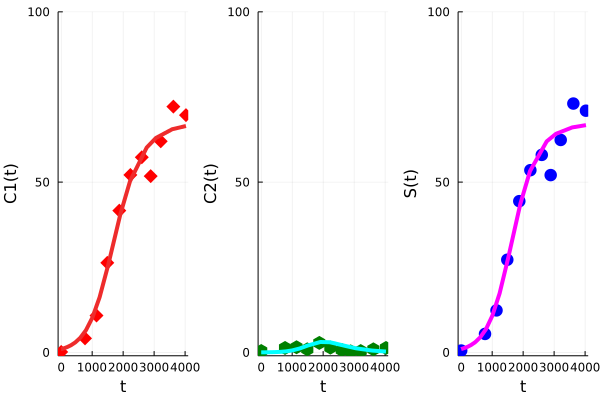

In [84]:
y1mle=zeros()
y2mle=zeros()
tt=zeros()
(y1mle,y2mle,tt)=odesolver2(t1,xopt[1],xopt[2],xopt[3],xopt[4],xopt[5],xopt[6])

p1=scatter(t1,data11,legend=false,msw=0,ms=7,color=:red,msa=:red,markershape=:diamond)
p1=plot!(tt,y1mle,color=:firebrick2,xlabel="t",ylabel="C1(t)",legend=false,lw=4,xlims=(-100,4100),ylims=(-1,100),xticks=[0,1000,2000,3000,4000],yticks=[0,50,100])
p2=scatter(t1,data12,legend=false,msw=0,ms=7,color=:green,msa=:green,markershape=:hexagon)
p2=plot!(tt,y2mle,color=:aqua,xlabel="t",ylabel="C2(t)",legend=false,lw=4,xlims=(-100,4100),ylims=(-1,100),xticks=[0,1000,2000,3000,4000],yticks=[0,50,100])
p3=scatter(t1,data11.+data12,legend=false,msw=0,ms=7,color=:blue,msa=:blue)
p3=plot!(tt,y1mle.+y2mle,color=:fuchsia,xlabel="t",ylabel="S(t)",legend=false,lw=4,xlims=(-100,4100),ylims=(-1,100),xticks=[0,1000,2000,3000,4000],yticks=[0,50,100])
p4=plot(p1,p2,p3,layout=(1,3),legend=false)
display(p4)

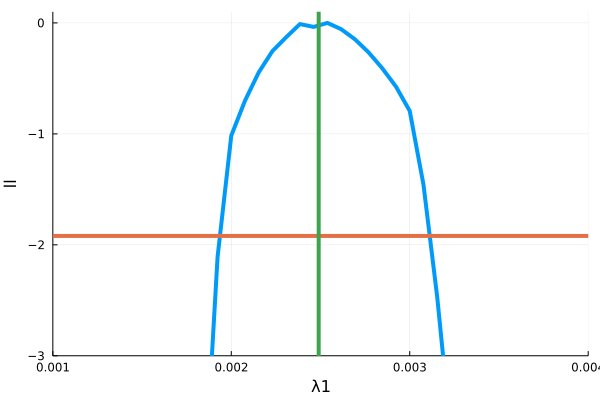

In [85]:
#Profile λ1
nptss=40
λ1min=0.001
λ1max=0.004
λ1range=LinRange(λ1min,λ1max,nptss)
nrange=zeros(6,nptss);
llλ1=zeros(nptss);
nllλ1=zeros(nptss);
predictC1λ1=zeros(length(tt),nptss)
predictC2λ1=zeros(length(tt),nptss)


for i in 1:nptss
function fun1(aa)
return error(data11,data12,[λ1range[i],aa[1],aa[2],aa[3],aa[4],aa[5],aa[6]])
end

lb1=    [λ2mle,δmle,Kmle,C01mle,C02mle,Vmle]/2.0;
ub1=2.0*[λ2mle,δmle,Kmle,C01mle,C02mle,Vmle];
θG1 = [λ2mle,δmle,Kmle,C01mle,C02mle,Vmle]
local (xo,fo)=optimise(fun1,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llλ1[i]=fo[1]
(predictC1λ1[:,i],predictC2λ1[:,i])=model(tt,[λ1range[i],nrange[1,i],nrange[2,i],nrange[3,i],nrange[4,i],nrange[5,i],nrange[6,i]])
end

nllλ1=llλ1.-maximum(llλ1);



C1λ1p=zeros(length(tt))
C1λ1m=1000*ones(length(tt))
C2λ1p=zeros(length(tt))
C2λ1m=1000*ones(length(tt))


for i in 1:nptss
if nllλ1[i] >= -1.921
    for j in 1:length(tt)
    C1λ1p[j]=max(predictC1λ1[j,i],C1λ1p[j])
    C1λ1m[j]=min(predictC1λ1[j,i],C1λ1m[j])
    C2λ1p[j]=max(predictC2λ1[j,i],C2λ1p[j])
    C2λ1m[j]=min(predictC2λ1[j,i],C2λ1m[j])

        end
end

end

s1=plot(λ1range,nllλ1,xlim=(λ1min,λ1max),ylim=(-3,0.1),lw=4,xlabel="λ1",ylabel="ll",legend=false)
s1=hline!([-1.92],lw=4)
s1=vline!([λ1mle],lw=4)
display(s1)

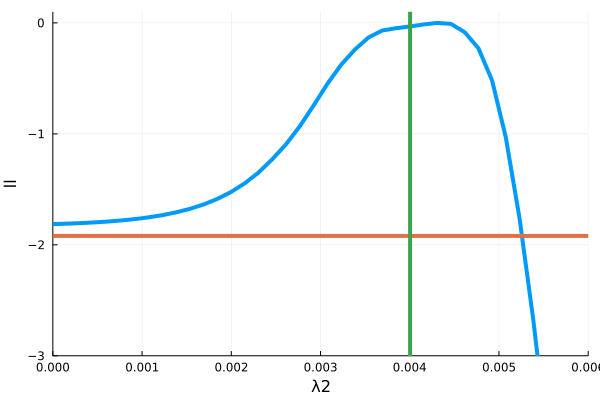

In [86]:
#Profile λ2
λ2min=0.000
λ2max=0.0060
λ2range=LinRange(λ2min,λ2max,nptss)
nrange=zeros(6,nptss);
llλ2=zeros(nptss);
nllλ2=zeros(nptss);
predictC1λ2=zeros(length(tt),nptss)
predictC2λ2=zeros(length(tt),nptss)


for i in 1:nptss
function fun2(aa)
return error(data11,data12,[aa[1],λ2range[i],aa[2],aa[3],aa[4],aa[5],aa[6]])
end
lb1=    [λ1mle,δmle,Kmle,C01mle,C02mle,Vmle]/1.5;
ub1=1.5*[λ1mle,δmle,Kmle,C01mle,C02mle,Vmle];
θG1 = [λ1mle,δmle,Kmle,C01mle,C02mle,Vmle]
local (xo,fo)=optimise(fun2,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llλ2[i]=fo[1]
(predictC1λ2[:,i],predictC2λ2[:,i])=model(tt,[nrange[1,i],λ2range[i],nrange[2,i],nrange[3,i],nrange[4,i],nrange[5,i],nrange[6,i]])

end

nllλ2=llλ2.-maximum(llλ2);

C1λ2p=zeros(length(tt))
C1λ2m=1000*ones(length(tt))
C2λ2p=zeros(length(tt))
C2λ2m=1000*ones(length(tt))


for i in 1:nptss
if nllλ2[i] >= -1.921
    for j in 1:length(tt)
    C1λ2p[j]=max(predictC1λ2[j,i],C1λ2p[j])
    C1λ2m[j]=min(predictC1λ2[j,i],C1λ2m[j])
    C2λ2p[j]=max(predictC2λ2[j,i],C2λ2p[j])
    C2λ2m[j]=min(predictC2λ2[j,i],C2λ2m[j])

        end
end

end

s2=plot(λ2range,nllλ2,xlim=(λ2min,λ2max),ylim=(-3,0.1),xlabel="λ2",ylabel="ll",legend=false,lw=4)
s2=hline!([-1.92],lw=4)
s2=vline!([λ2mle],lw=4)
display(s2)

In [87]:
#Profile d2
δmin=-0.001
δmax=0.01
δrange=LinRange(δmin,δmax,nptss)
nrange=zeros(6,nptss);
llδ=zeros(nptss);
nllδ=zeros(nptss);
predictC1δ=zeros(length(tt),nptss)
predictC2δ=zeros(length(tt),nptss)

for i in 1:nptss
function fun3(aa)
return error(data11,data12,[aa[1],aa[2],δrange[i],aa[3],aa[4],aa[5],aa[6]])
end
lb1=    [λ1mle,λ2mle,Kmle,C01mle,C02mle,Vmle]/1.5;
ub1=1.5*[λ1mle,λ2mle,Kmle,C01mle,C02mle,Vmle];
θG1 = [λ1mle,λ2mle,Kmle,C01mle,C02mle,Vmle]
local (xo,fo)=optimise(fun3,θG1,lb1,ub1)
nrange[:,i]=xo[:]
lld2[i]=fo[1]
(predictC1δ[:,i],predictC2δ[:,i])=model(tt,[nrange[1,i],nrange[2,i],δrange[i],nrange[3,i],nrange[4,i],nrange[5,i],nrange[6,i]])
end

nllδ=llδ.-maximum(llδ);

C1δp=zeros(length(tt))
C1δm=1000*ones(length(tt))
C2δp=zeros(length(tt))
C2δm=1000*ones(length(tt))


for i in 1:nptss
if nlld2[i] >= -1.921
    for j in 1:length(tt)
    C1δp[j]=max(predictC1δ[j,i],C1δp[j])
    C1δm[j]=min(predictC1δ[j,i],C1δm[j])
    C2δp[j]=max(predictC2δ[j,i],C2δp[j])
    C2δm[j]=min(predictC2δ[j,i],C2δm[j])

        end
end

end


s3=plot(δrange,nlld2,xlim=(δmin,δmax),ylim=(-3,0.1),xlabel="d2",ylabel="ll",legend=false,lw=4)
s3=hline!([-1.92],lw=4)
s3=vline!([δmle],lw=4)
display(s3)

LoadError: BoundsError: attempt to access 20-element Vector{Float64} at index [21]

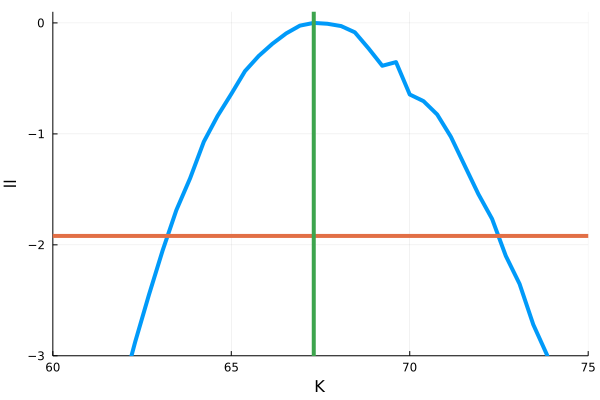

In [88]:
#Profile K
Kmin=60
Kmax=75
Krange=LinRange(Kmin,Kmax,nptss)
nrange=zeros(6,nptss);
llK=zeros(nptss);
nllK=zeros(nptss);
predictC1K=zeros(length(tt),nptss)
predictC2K=zeros(length(tt),nptss)

for i in 1:nptss
function fun4(aa)
return error(data11,data12,[aa[1],aa[2],aa[3],Krange[i],aa[4],aa[5],aa[6]])
end

lb1=    [λ1mle,λ2mle,δmle,C01mle,C02mle,Vmle]/1.5;
ub1=1.5*[λ1mle,λ2mle,δmle,C01mle,C02mle,Vmle];
θG1 = [λ1mle,λ2mle,δmle,C01mle,C02mle,Vmle]
local (xo,fo)=optimise(fun4,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llK[i]=fo[1]
(predictC1K[:,i],predictC2K[:,i])=model(tt,[nrange[1,i],nrange[2,i],nrange[3,i],Krange[i],nrange[4,i],nrange[5,i],nrange[6,i]])
end

nllK=llK.-maximum(llK);


C1Kp=zeros(length(tt))
C1Km=1000*ones(length(tt))
C2Kp=zeros(length(tt))
C2Km=1000*ones(length(tt))


for i in 1:nptss
if nllK[i] >= -1.921
    for j in 1:length(tt)
    C1Kp[j]=max(predictC1K[j,i],C1Kp[j])
    C1Km[j]=min(predictC1K[j,i],C1Km[j])
    C2Kp[j]=max(predictC2K[j,i],C2Kp[j])
    C2Km[j]=min(predictC2K[j,i],C2Km[j])

        end
end

end

s4=plot(Krange,nllK,xlim=(Kmin,Kmax),ylim=(-3.0,0.1),xlabel="K",ylabel="ll",legend=false,lw=4)
s4=hline!([-1.92],lw=4)
s4=vline!([Kmle],lw=4)
display(s4)

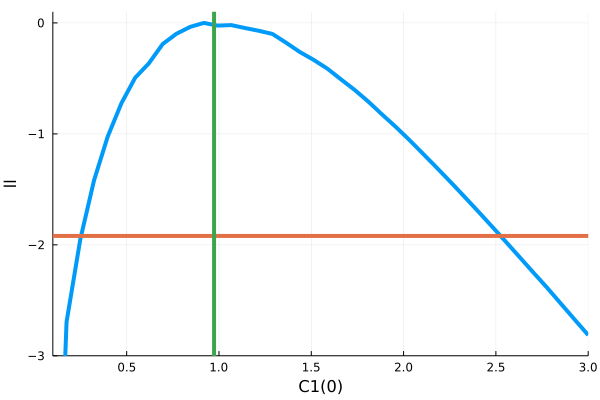

In [89]:
#Profile C10
C01min=0.1
C01max=3.0
C01range=LinRange(C01min,C01max,nptss)
nrange=zeros(6,nptss);
llC01=zeros(nptss);
nllC01=zeros(nptss);
predictC1C01=zeros(length(tt),nptss)
predictC2C01=zeros(length(tt),nptss)

for i in 1:nptss
function fun5(aa)
return error(data11,data12,[aa[1],aa[2],aa[3],aa[4],C01range[i],aa[5],aa[6]])
end
lb1=    [λ1mle,λ2mle,δmle,Kmle,C02mle,Vmle]/1.5;
ub1=1.5*[λ1mle,λ2mle,δmle,Kmle,C02mle,Vmle];
θG1 = [λ1mle,λ2mle,δmle,Kmle,C02mle,Vmle]
local (xo,fo)=optimise(fun5,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llC01[i]=fo[1]
(predictC1C01[:,i],predictC2C01[:,i])=model(tt,[nrange[1,i],nrange[2,i],nrange[3,i],nrange[4,i],C01range[i],nrange[5,i],nrange[6,i]])
end

nllC01=llC01.-maximum(llC01);

C1C01p=zeros(length(tt))
C1C01m=1000*ones(length(tt))
C2C01p=zeros(length(tt))
C2C01m=1000*ones(length(tt))


for i in 1:nptss
if nllC01[i] >= -1.921
    for j in 1:length(tt)
    C1C01p[j]=max(predictC1C01[j,i],C1C01p[j])
    C1C01m[j]=min(predictC1C01[j,i],C1C01m[j])
    C2C01p[j]=max(predictC2C01[j,i],C2C01p[j])
    C2C01m[j]=min(predictC2C01[j,i],C2C01m[j])

        end
end

end

s5=plot(C01range,nllC01,xlim=(C01min,C01max),ylim=(-3,0.1),xlabel="C1(0)",ylabel="ll",legend=false,lw=4)
s5=hline!([-1.92],lw=4)
s5=vline!([C01mle],lw=4)
display(s5)


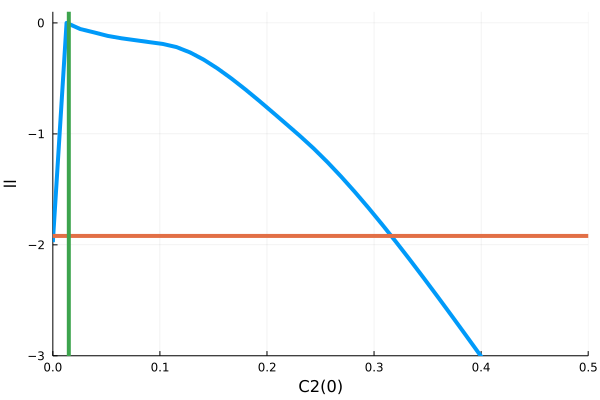

In [90]:
#Profile C20
C02min=0.0
C02max=0.5
C02range=LinRange(C02min,C02max,nptss)
nrange=zeros(6,nptss);
llC02=zeros(nptss);
nllC02=zeros(nptss);
predictC1C02=zeros(length(tt),nptss)
predictC2C02=zeros(length(tt),nptss)


for i in 1:nptss
function fun6(aa)
return error(data11,data12,[aa[1],aa[2],aa[3],aa[4],aa[5],C02range[i],aa[6]])
end

lb1=    [λ1mle,λ2mle,δmle,Kmle,C01mle,Vmle]/1.5;
ub1=1.5*[λ1mle,λ2mle,δmle,Kmle,C01mle,Vmle];
θG1 = [λ1mle,λ2mle,δmle,Kmle,C01mle,Vmle]
local (xo,fo)=optimise(fun6,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llC02[i]=fo[1]
(predictC1C02[:,i],predictC2C02[:,i])=model(tt,[nrange[1,i],nrange[2,i],nrange[3,i],nrange[4,i],nrange[5,i],C02range[i],nrange[6,i]])    
end

nllC02=llC02.-maximum(llC02);


C1C02p=zeros(length(tt))
C1C02m=1000*ones(length(tt))
C2C02p=zeros(length(tt))
C2C02m=1000*ones(length(tt))


for i in 1:nptss
if nllC02[i] >= -1.921
    for j in 1:length(tt)
    C1C02p[j]=max(predictC1C02[j,i],C1C02p[j])
    C1C02m[j]=min(predictC1C02[j,i],C1C02m[j])
    C2C02p[j]=max(predictC2C02[j,i],C2C02p[j])
    C2C02m[j]=min(predictC2C02[j,i],C2C02m[j])

        end
end

end


s6=plot(C02range,nllC02,xlim=(C02min,C02max),ylim=(-3,0.1),xlabel="C2(0)",ylabel="ll",legend=false,lw=4)
s6=hline!([-1.92],lw=4)
s6=vline!([C02mle],lw=4)
display(s6)


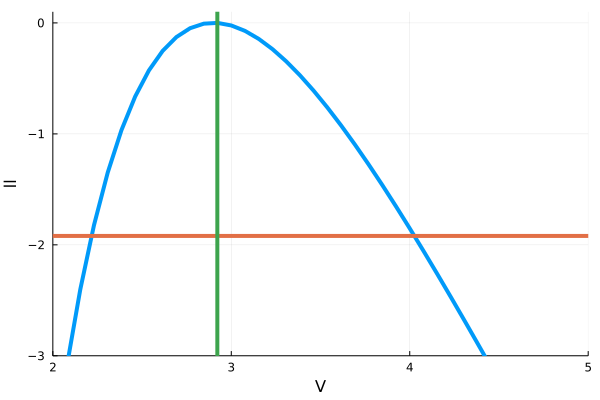

In [91]:
#Profile V
Vmin=2.0
Vmax=5.0
Vrange=LinRange(Vmin,Vmax,nptss)
nrange=zeros(6,nptss);
llV=zeros(nptss);
nllV=zeros(nptss);

for i in 1:nptss
function fun7(aa)
return error(data11,data12,[aa[1],aa[2],aa[3],aa[4],aa[5],aa[6],Vrange[i]])
end

lb1=    [λ1mle,λ2mle,δmle,Kmle,C01mle,C02mle]/1.5;
ub1=1.5*[λ1mle,λ2mle,δmle,Kmle,C01mle,C02mle];
θG1 = [λ1mle,λ2mle,δmle,Kmle,C01mle,C02mle]
local (xo,fo)=optimise(fun7,θG1,lb1,ub1)
nrange[:,i]=xo[:]
llV[i]=fo[1]
end

nllV=llV.-maximum(llV);


s7=plot(Vrange,nllV,xlim=(Vmin,Vmax),ylim=(-3,0.1),xlabel="V",ylabel="ll",legend=false,lw=4)
s7=hline!([-1.92],lw=4)
s7=vline!([Vmle],lw=4)
display(s7)


f1=LinearInterpolation(Vrange,nllV);
aa=2.5;
bb=3.0;
while (bb-aa) >= 0.00000001
cc = (aa+bb)/2.0
    if sign(f1(cc)+1.92) == sign(f1(aa)+1.92)
        aa=cc
    else
        bb=cc
    end
end

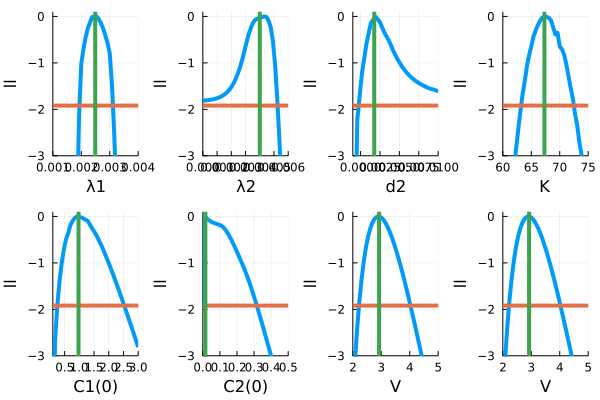

In [92]:
s8=plot(s1,s2,s3,s4,s5,s6,s7,s7,layout=(2,4),legend=false)
display(s8)
#savefig(s8,"profiles2.pdf")

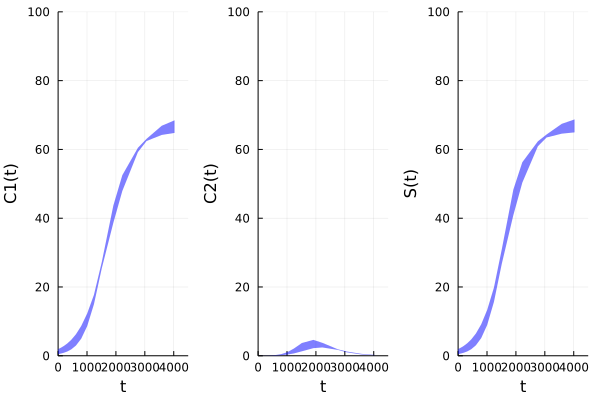

In [93]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1λ1m,C1λ1p.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2λ1m,C2λ1p.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1λ1m.+C2λ1m),(C1λ1p.+C2λ1p).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

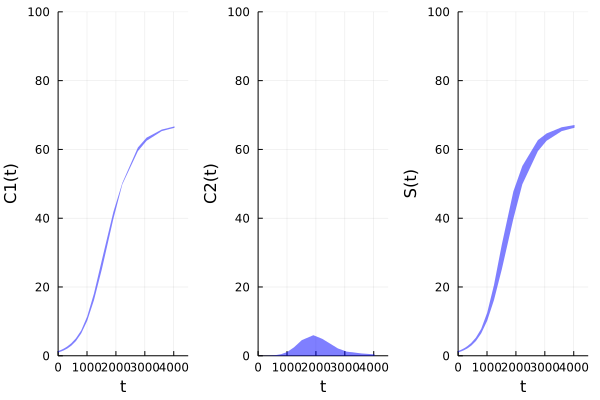

In [94]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1λ2m,C1λ2p.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2λ2m,C2λ2p.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1λ2m.+C2λ2m),(C1λ2p.+C2λ2p).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

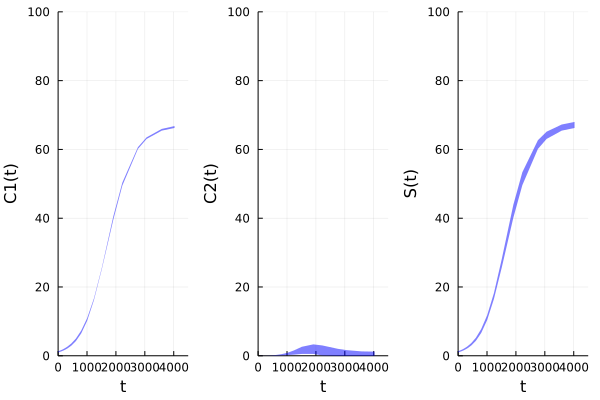

In [95]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1δm,C1δp.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2δm,C2δp.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1δm.+C2δm),(C1δp.+C2δp).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

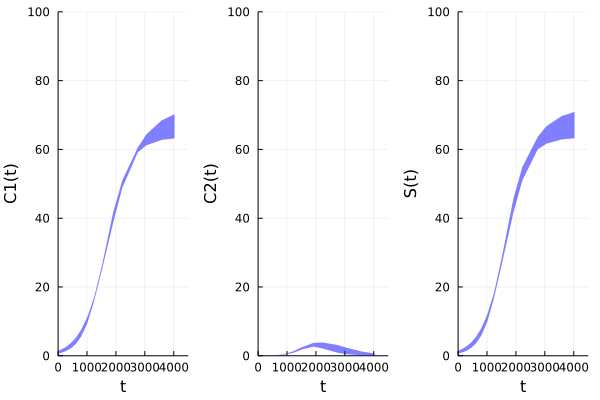

In [96]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1Km,C1Kp.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2Km,C2Kp.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1Km.+C2Km),(C1Kp.+C2Kp).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

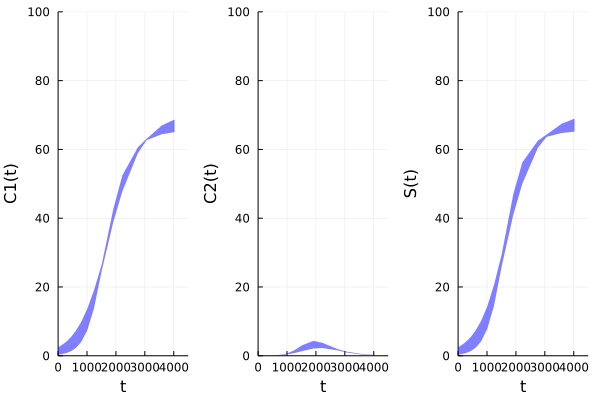

In [97]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1C01m,C1C01p.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2C01m,C2C01p.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1C01m.+C2C01m),(C1C01p.+C2C01p).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

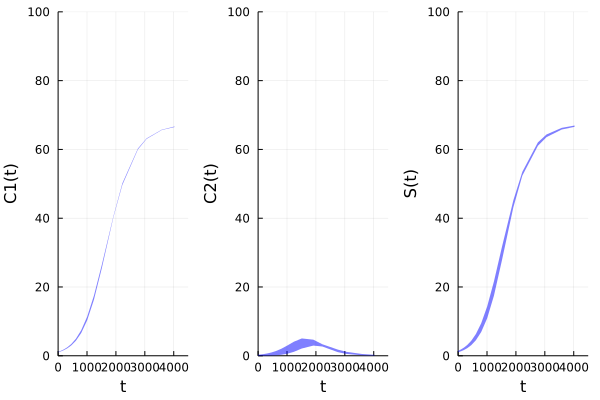

In [98]:
r1=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1C02m,C1C02p.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
r2=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2C02m,C2C02p.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
r3=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1C02m.+C2C02m),(C1C02p.+C2C02p).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
r4=plot(r1,r2,r3,layout=(1,3),legend=false)
display(r4)

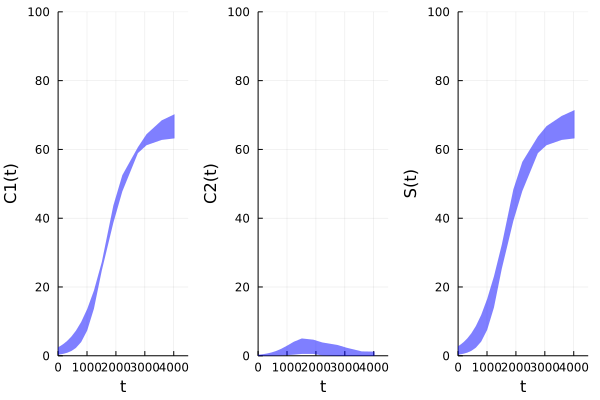

In [99]:
C1Up=zeros(length(tt))
C1Um=zeros(length(tt))
for i in 1:length(tt)
C1Up[i] = max(C1λ1p[i],C1λ1p[i],C1δp[i],C1Kp[i],C1C01p[i],C1C02p[i])
C1Um[i] = min(C1λ1m[i],C1λ1m[i],C1δm[i],C1Km[i],C1C01m[i],C1C02m[i])
end

C2Up=zeros(length(tt))
C2Um=zeros(length(tt))
for i in 1:length(tt)
C2Up[i] = max(C2λ1p[i],C2λ1p[i],C2δp[i],C2Kp[i],C2C01p[i],C2C02p[i])
C2Um[i] = min(C2λ1m[i],C2λ1m[i],C2δm[i],C2Km[i],C2C01m[i],C2C02m[i])
end



qq5=plot(tt,y1mle,w=0,c=:blue,ribbon=(y1mle.-C1Um,C1Up.-y1mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C1(t)")
qq6=plot(tt,y2mle,w=0,c=:blue,ribbon=(y2mle.-C2Um,C2Up.-y2mle),fillalpha=.5,xlim=(0,4500),ylim=(0,100),xticks=[0,1000,2000,3000,4000],legend=false,xlabel="t",ylabel="C2(t)")
qq7=plot(tt,y1mle.+y2mle,w=0,c=:blue,ribbon=((y1mle.+y2mle).-(C1Um.+C2Um),(C1Up.+C2Up).-(y1mle.+y2mle)),fillalpha=.5,xlim=(0,4500),xticks=[0,1000,2000,3000,4000],ylim=(0,100),legend=false,xlabel="t",ylabel="S(t)")
rr4=plot(qq5,qq6,qq7,layout=(1,3),legend=false)
display(rr4)

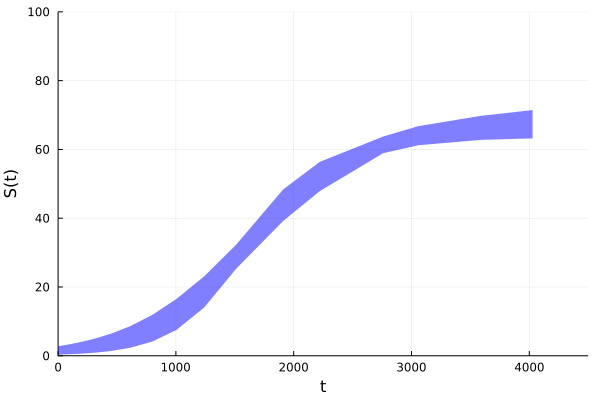

In [100]:
display(qq7)

In [101]:
savefig(qq7, "Union2.pdf")